In [106]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from dotenv import load_dotenv
from google import genai
import glob


In [28]:
user_items_df = pd.read_csv('/Users/vince/Salk/mCC_Analysis/data/compliant_user_items.csv')

# Load JSON file containing food corrections
with open('/Users/vince/Salk/mCC_Analysis/food_corrections.json', 'r') as f:
    food_corrections = json.load(f)

# Create a new column with corrected food names
user_items_df['corrected_food'] = user_items_df['parsing_result'].map(food_corrections).str.lower()

In [57]:

def load_food_json_files(directory='food_info'):
    """
    Load all JSON files from the specified directory
    
    Args:
        directory (str): Directory containing food JSON files
        
    Returns:
        dict: Dictionary with food item names as keys and their data as values
    """
    food_data = {}
    json_files = glob.glob(os.path.join(directory, '*.json'))
    
    print(f"Found {len(json_files)} JSON files in {directory}")
    
    for file_path in tqdm(json_files, desc="Loading JSON files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            # Using filename (without extension) as the key
            food_name = os.path.splitext(os.path.basename(file_path))[0]
            food_data[food_name] = data
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return food_data

all_food_data = load_food_json_files("/Users/vince/Salk/mCC_Analysis/food_info")

Found 2664 JSON files in /Users/vince/Salk/mCC_Analysis/food_info


Loading JSON files: 100%|██████████| 2664/2664 [00:00<00:00, 5288.26it/s]


In [59]:
all_food_data['chocolate_cookie']

{'food_name': 'Chocolate Cookie',
 'description': 'A sweet baked treat flavored with chocolate.',
 'serving_size': {'grams': 30.0, 'household': '1 medium cookie'},
 'macronutrients_per_100g': {'calories': 480.0,
  'protein': 5.0,
  'fat': 25.0,
  'carbohydrates': 60.0,
  'fiber': 2.0,
  'sugar': 30.0},
 'taxonomy': ['Snacks', 'Baked Goods', 'Cookies', 'Chocolate Cookies'],
 'ingredients': ['Wheat Flour',
  'Sugar',
  'Butter',
  'Chocolate Chips',
  'Eggs',
  'Cocoa Powder',
  'Vanilla Extract',
  'Baking Soda',
  'Salt'],
 'variants': ['Double Chocolate Cookie',
  'Chocolate Chip Cookie',
  'Dark Chocolate Cookie',
  'Milk Chocolate Cookie']}

In [71]:
from google import genai
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Assuming client is already set up
client = genai.Client(api_key=GOOGLE_API_KEY)

def batch_get_embeddings(items, batch_size=100):
    """
    Get embeddings for multiple texts using the batch embedding API
    """
    all_embeddings = {}
    
    # Process in batches
    for i in tqdm(range(0, len(items), batch_size), desc="Processing embedding batches"):
        batch = items[i:i+batch_size]
        batch_contents = [json.dumps(all_food_data[item]) for item in batch]
        
        try:
            # Use the batch embedding endpoint
            response = client.models.embed_content(
                model="text-embedding-004",
                contents=list(batch_contents)
            )
            
            # Extract embeddings
            for idx, embedding_result in enumerate(response.embeddings):
                item = batch[idx]
                item_text = batch_contents[idx]
                all_embeddings[item] = {}
                all_embeddings[item]['item_text'] = item_text
                all_embeddings[item]['embedding'] = np.array(embedding_result.values)
                
            # Small delay between batch requests if needed
            if i + batch_size < len(items):
                time.sleep(0.5)
                
        except Exception as e:
            print(f"Error in batch {i//batch_size + 1}: {e}")
            # Fall back to individual requests for this batch
            for item in batch:
                try:
                    response = client.models.embed_content(
                        model="text-embedding-004",
                        contents=item
                    )
                    all_embeddings[item] = np.array(response.embedding.values)
                except Exception as inner_e:
                    print(f"Failed to get embedding for '{item[:50]}...': {inner_e}")
    
    return all_embeddings

all_food_data_list = list(all_food_data)

embeddings_dict = batch_get_embeddings(all_food_data_list)

Processing embedding batches: 100%|██████████| 27/27 [00:39<00:00,  1.47s/it]


In [101]:
import pickle

pickle.dump(embeddings_dict, open('gemini_food_embeddings_dict.pkl', 'wb'))

In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import pickle
from itertools import combinations

def load_embeddings(embeddings_dict):
    """
    Convert the embeddings dictionary to a format suitable for pairwise comparisons
    """
    # Create a mapping of food names to their embeddings
    food_embeddings = {}
    for food_name, data in embeddings_dict.items():
        food_embeddings[food_name] = data['embedding']
    
    return food_embeddings

def calculate_pairwise_similarities(embeddings, threshold=0.9):
    """
    Calculate pairwise cosine similarities between embeddings
    and return pairs with similarity above the threshold
    
    Args:
        embeddings (dict): Dictionary mapping food names to embedding arrays
        threshold (float): Minimum similarity threshold
        
    Returns:
        list: List of tuples (food1, food2, similarity) sorted by similarity
    """
    food_names = list(embeddings.keys())
    similar_pairs = []
    
    # Create a progress bar for the comparison process
    total_comparisons = (len(food_names) * (len(food_names) - 1)) // 2
    pbar = tqdm(total=total_comparisons, desc="Calculating similarities")
    
    # Iterate through all unique pairs
    for i, food1 in enumerate(food_names):
        for j in range(i + 1, len(food_names)):
            food2 = food_names[j]
            
            # Calculate cosine similarity
            embed1 = embeddings[food1].reshape(1, -1)
            embed2 = embeddings[food2].reshape(1, -1)
            similarity = cosine_similarity(embed1, embed2)[0][0]
            
            # Store pairs with similarity above threshold
            if similarity > threshold:
                similar_pairs.append((food1, food2, similarity))
            
            pbar.update(1)
    
    pbar.close()
    
    # Sort by similarity (highest first)
    similar_pairs.sort(key=lambda x: x[2], reverse=True)
    
    return similar_pairs

def batch_calculate_similarities(embeddings, threshold=0.9, batch_size=1000):
    """
    Calculate pairwise similarities in batches to save memory
    
    Args:
        embeddings (dict): Dictionary mapping food names to embedding arrays
        threshold (float): Minimum similarity threshold
        batch_size (int): Number of pairs to process at once
        
    Returns:
        list: List of tuples (food1, food2, similarity) sorted by similarity
    """
    food_names = list(embeddings.keys())
    similar_pairs = []
    
    # Get all combinations of food pairs
    all_pairs = list(combinations(food_names, 2))
    total_pairs = len(all_pairs)
    
    print(f"Processing {total_pairs} pairs in batches of {batch_size}")
    
    # Process in batches
    for i in tqdm(range(0, total_pairs, batch_size), desc="Processing batches"):
        batch_pairs = all_pairs[i:i+batch_size]
        batch_similarities = []
        
        for food1, food2 in batch_pairs:
            embed1 = embeddings[food1].reshape(1, -1)
            embed2 = embeddings[food2].reshape(1, -1)
            similarity = cosine_similarity(embed1, embed2)[0][0]
            
            if similarity > threshold:
                batch_similarities.append((food1, food2, similarity))
        
        similar_pairs.extend(batch_similarities)
    
    # Sort by similarity (highest first)
    similar_pairs.sort(key=lambda x: x[2], reverse=True)
    
    return similar_pairs

def print_similar_items(similar_pairs, food_data, top_n=None):
    """
    Print the similar food pairs along with their names
    
    Args:
        similar_pairs (list): List of tuples (food1, food2, similarity)
        food_data (dict): Dictionary containing food data
        top_n (int, optional): Number of top pairs to print
    """
    if top_n:
        pairs_to_print = similar_pairs[:top_n]
    else:
        pairs_to_print = similar_pairs
    
    print(f"Found {len(similar_pairs)} similar food pairs (similarity > {threshold}):")
    print("-" * 80)
    
    for food1, food2, similarity in pairs_to_print:
        print(f"Similarity: {similarity:.4f}")
        print(f"Food 1: {food1}")
        print(f"Food 2: {food2}")
        
        # If available, print some data about each food
        try:
            food1_data = json.loads(food_data[food1]['item_text'])
            food2_data = json.loads(food_data[food2]['item_text'])
            
            # Print a basic field if available (adjust based on your data structure)
            if 'description' in food1_data:
                print(f"Food 1 description: {food1_data['description']}")
            if 'description' in food2_data:
                print(f"Food 2 description: {food2_data['description']}")
        except:
            # Skip detailed info if there's an issue
            pass
            
        print("-" * 80)

def save_similar_pairs(similar_pairs, filename="similar_food_pairs.csv"):
    """
    Save the similar pairs to a CSV file
    """
    df = pd.DataFrame(similar_pairs, columns=['food1', 'food2', 'similarity'])
    df.to_csv(filename, index=False)
    print(f"Saved {len(similar_pairs)} similar pairs to {filename}")
    
    return df


# Option 1: If embeddings are already loaded in memory
# Extract just the embeddings from the dictionary
food_embeddings = load_embeddings(embeddings_dict)



In [75]:
threshold = 0.9

similar_pairs = calculate_pairwise_similarities(food_embeddings, threshold=threshold)

Calculating similarities: 100%|██████████| 3547116/3547116 [06:52<00:00, 8606.12it/s]


In [108]:
similar_pairs[-20:]

[('cucumber_salad', 'barbecue_chicken_salad', np.float64(0.9000413894830549)),
 ('egg_salad_sandwich', 'turkey_salad', np.float64(0.9000401158799839)),
 ('mint_chocolate', 'godiva', np.float64(0.9000394786496788)),
 ('yakult', 'yoplait', np.float64(0.90003188501249)),
 ('chicken_leg', 'chicken_cutlet', np.float64(0.9000318104841388)),
 ('lime_soda', 'diet_cola', np.float64(0.9000308172961899)),
 ('wheat_english_muffin', 'bread', np.float64(0.9000307373384551)),
 ('noodle_soup', 'chicken_stock', np.float64(0.9000262205376779)),
 ('soup', 'tonkotsu_ramen', np.float64(0.900025904276282)),
 ('cheerio', 'rice_krispies_treat', np.float64(0.9000250051656216)),
 ('vegan_ice_cream', 'haagen_dazs', np.float64(0.9000219884336359)),
 ('pumpkin_soup', 'vegetable_broth', np.float64(0.9000146501714616)),
 ('lollipop', 'gummy', np.float64(0.9000129006374689)),
 ('miso_soup', 'onion_soup', np.float64(0.9000106431753546)),
 ('khichdi', 'poha', np.float64(0.9000067552374066)),
 ('bean_cheese_burrito', 'c

In [102]:
pickle.dump(similar_pairs, open('gemini_food_similar_pairs.pkl', 'wb'))

In [76]:
print_similar_items(similar_pairs, embeddings_dict, top_n=20)

Found 12208 similar food pairs (similarity > 0.9):
--------------------------------------------------------------------------------
Similarity: 1.0000
Food 1: ipa_beer
Food 2: ipa
Food 1 description: A hoppy style of beer within the broader category of pale ale.
Food 2 description: A hoppy style of beer within the broader category of pale ale.
--------------------------------------------------------------------------------
Similarity: 1.0000
Food 1: chia
Food 2: chia_seed
Food 1 description: Small, edible seeds from the Salvia hispanica plant, known for their high fiber, omega-3 fatty acid, and protein content.
Food 2 description: Small, edible seeds from the Salvia hispanica plant, known for their high fiber, omega-3 fatty acid, and protein content.
--------------------------------------------------------------------------------
Similarity: 0.9998
Food 1: pepper_jack
Food 2: pepper_jack_cheese
Food 1 description: Semi-soft cheese flavored with spicy peppers.
Food 2 description: Semi-s

In [78]:
similar_pairs[-10:]

[('vegan_ice_cream', 'haagen_dazs', np.float64(0.9000219884336359)),
 ('pumpkin_soup', 'vegetable_broth', np.float64(0.9000146501714616)),
 ('lollipop', 'gummy', np.float64(0.9000129006374689)),
 ('miso_soup', 'onion_soup', np.float64(0.9000106431753546)),
 ('khichdi', 'poha', np.float64(0.9000067552374066)),
 ('bean_cheese_burrito', 'carnitas_taco', np.float64(0.9000062075060334)),
 ('pu_erh_tea', 'breakfast_tea', np.float64(0.9000035333574101)),
 ('ricotta', 'cottage_cheese', np.float64(0.9000012837443957)),
 ('pound_cake', 'olive_oil_cake', np.float64(0.9000010617946483)),
 ('crack_bread', 'cheese_bread', np.float64(0.9000008222327027))]

# Clustering

In [83]:
# Import libraries without UMAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

In [84]:
# Extract embeddings into a numpy array
food_names = list(embeddings_dict.keys())
embeddings_array = np.array([embeddings_dict[name]['embedding'] for name in food_names])

print(f"Shape of embeddings array: {embeddings_array.shape}")

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(embeddings_array)

# Create a DataFrame with the reduced dimensions
reduced_df = pd.DataFrame({
    'food_name': food_names,
    'pca_1': pca_embeddings[:, 0],
    'pca_2': pca_embeddings[:, 1]
})

print(f"PCA reduction complete. Shape: {pca_embeddings.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Shape of embeddings array: (2664, 768)
PCA reduction complete. Shape: (2664, 2)
Explained variance ratio: [0.04896953 0.04126427]


In [85]:
# t-SNE for dimensionality reduction (can take a while to run)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Add t-SNE dimensions to the DataFrame
reduced_df['tsne_1'] = tsne_embeddings[:, 0]
reduced_df['tsne_2'] = tsne_embeddings[:, 1]

print(f"t-SNE reduction complete. Shape: {tsne_embeddings.shape}")

/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE reduction complete. Shape: (2664, 2)


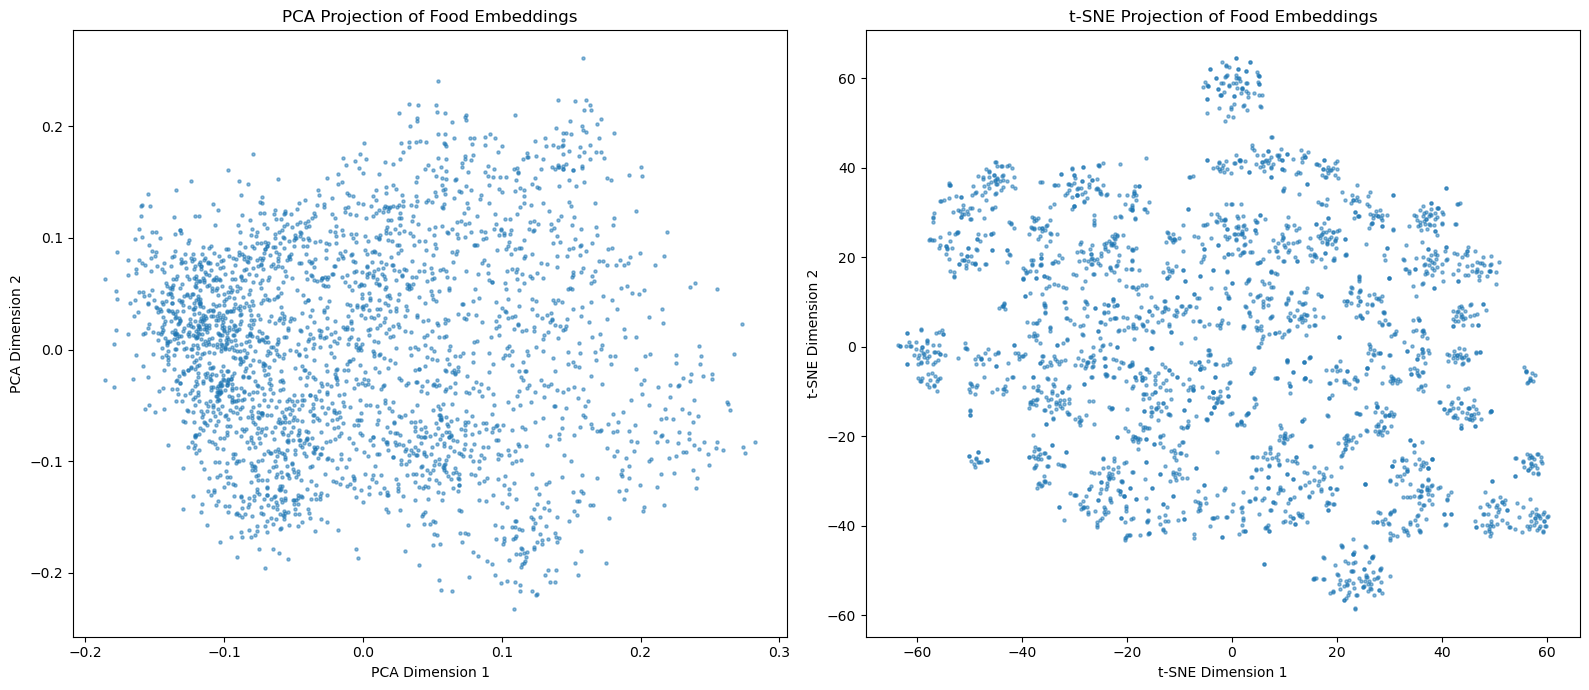

In [86]:
# Create a combined visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot PCA
axes[0].scatter(reduced_df['pca_1'], reduced_df['pca_2'], alpha=0.5, s=5)
axes[0].set_title('PCA Projection of Food Embeddings')
axes[0].set_xlabel('PCA Dimension 1')
axes[0].set_ylabel('PCA Dimension 2')

# Plot t-SNE
axes[1].scatter(reduced_df['tsne_1'], reduced_df['tsne_2'], alpha=0.5, s=5)
axes[1].set_title('t-SNE Projection of Food Embeddings')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

DBSCAN found 104 clusters and 1932 noise points


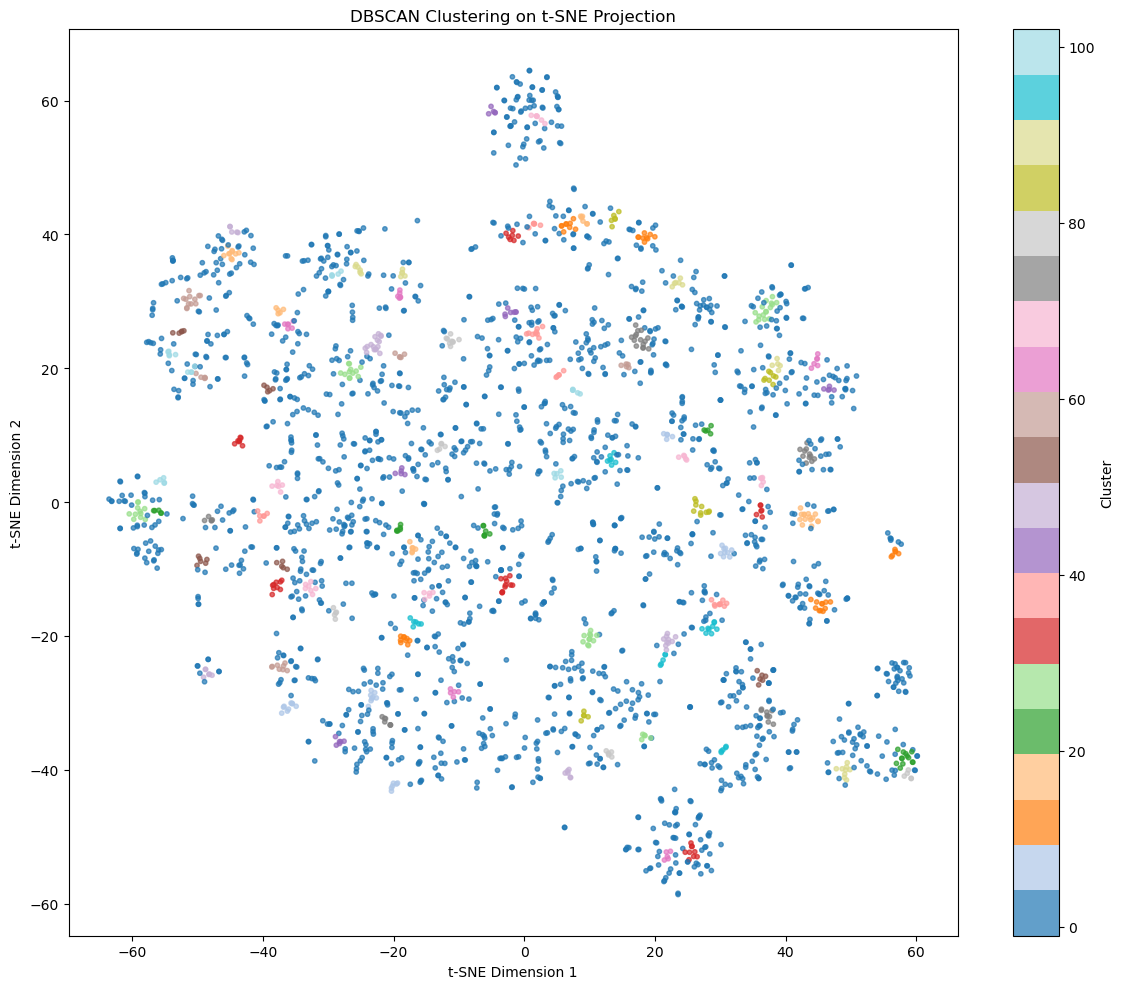

In [87]:
# DBSCAN clustering on t-SNE embeddings
# You may need to experiment with eps and min_samples
eps = 1.0  # Adjust based on your data
min_samples = 5  # Adjust based on your data
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
reduced_df['dbscan_cluster'] = dbscan.fit_predict(tsne_embeddings)

# Count number of clusters found (excluding noise)
n_clusters = len(set(reduced_df['dbscan_cluster'])) - (1 if -1 in reduced_df['dbscan_cluster'] else 0)
print(f"DBSCAN found {n_clusters} clusters and {(reduced_df['dbscan_cluster'] == -1).sum()} noise points")

# Visualize DBSCAN clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_df['tsne_1'], reduced_df['tsne_2'], 
                     c=reduced_df['dbscan_cluster'], cmap='tab20', 
                     alpha=0.7, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title(f'DBSCAN Clustering on t-SNE Projection')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

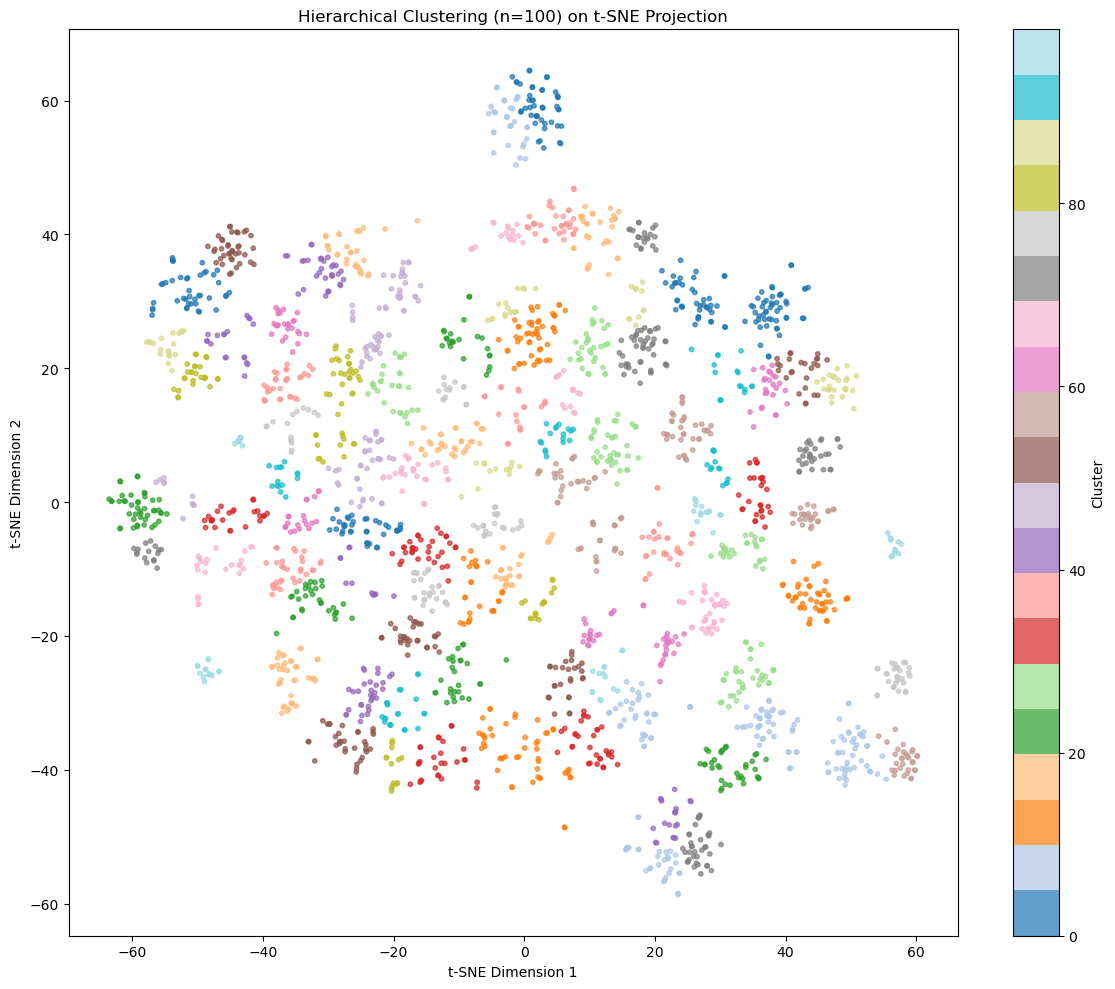

In [91]:
# Hierarchical clustering on t-SNE embeddings
n_clusters = 100  # Adjust based on your data
agglom = AgglomerativeClustering(n_clusters=n_clusters)
reduced_df['hierarchical_cluster'] = agglom.fit_predict(tsne_embeddings)

# Visualize hierarchical clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_df['tsne_1'], reduced_df['tsne_2'], 
                     c=reduced_df['hierarchical_cluster'], cmap='tab20', 
                     alpha=0.7, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Hierarchical Clustering (n={n_clusters}) on t-SNE Projection')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

In [104]:
# Function to get representative items from each cluster considering both centroid proximity and frequency
def get_weighted_cluster_representatives(df, cluster_col, embedding_cols, frequency_series, n=5, 
                                         centroid_weight=0.7, frequency_weight=0.3):
    """
    Return n representative items from each cluster based on both:
    1) Proximity to cluster centroid
    2) Frequency of occurrence in user_items_df
    
    Args:
        df: DataFrame with food embeddings and cluster assignments
        cluster_col: Column name with cluster assignments
        embedding_cols: Columns containing the reduced dimensions
        frequency_series: Series with frequency counts for each food
        n: Number of representatives to return
        centroid_weight: Weight given to centroid proximity (0-1)
        frequency_weight: Weight given to frequency (0-1)
    """
    cluster_reps = {}
    
    # Normalize weights
    total_weight = centroid_weight + frequency_weight
    centroid_weight = centroid_weight / total_weight
    frequency_weight = frequency_weight / total_weight
    
    # Process each cluster
    for cluster in sorted(df[cluster_col].unique()):
        if cluster == -1:  # Skip noise points (for DBSCAN)
            continue
            
        # Get items in this cluster
        cluster_items = df[df[cluster_col] == cluster].copy()
        
        # Get the centroid of this cluster in embedding space
        centroid = cluster_items[embedding_cols].mean().values
        
        # Calculate distance to centroid for each point
        cluster_items['dist_to_centroid'] = cluster_items.apply(
            lambda row: np.sqrt(sum((row[col] - centroid[i])**2 for i, col in enumerate(embedding_cols))),
            axis=1
        )
        
        # Normalize distances to 0-1 scale (smaller is better)
        if len(cluster_items) > 1:  # Only normalize if there's more than one item
            min_dist = cluster_items['dist_to_centroid'].min()
            max_dist = cluster_items['dist_to_centroid'].max()
            if max_dist > min_dist:  # Avoid division by zero
                cluster_items['normalized_dist'] = 1 - ((cluster_items['dist_to_centroid'] - min_dist) / (max_dist - min_dist))
            else:
                cluster_items['normalized_dist'] = 1.0
        else:
            cluster_items['normalized_dist'] = 1.0
        
        # Add frequency information
        cluster_items['frequency'] = cluster_items['food_name'].map(
            lambda x: frequency_series.get(x, 0)
        )
        
        # Normalize frequency to 0-1 scale (larger is better)
        max_freq = cluster_items['frequency'].max()
        if max_freq > 0:  # Avoid division by zero
            cluster_items['normalized_freq'] = cluster_items['frequency'] / max_freq
        else:
            cluster_items['normalized_freq'] = 0
        
        # Calculate combined score
        cluster_items['combined_score'] = (
            centroid_weight * cluster_items['normalized_dist'] + 
            frequency_weight * cluster_items['normalized_freq']
        )
        
        # Get top n items by combined score
        representatives = cluster_items.nlargest(n, 'combined_score')
        
        # Store these representatives
        cluster_reps[cluster] = representatives[['food_name', 'normalized_dist', 
                                                'frequency', 'combined_score']].to_dict('records')
    
    return cluster_reps

# Apply to hierarchical clusters with user frequency information
# Assuming user_items_frequency is a Series with food names as index and counts as values
user_items_frequency = user_items_df['corrected_food'].value_counts()

weighted_representatives = get_weighted_cluster_representatives(
    reduced_df, 
    'hierarchical_cluster', 
    ['tsne_1', 'tsne_2'], 
    user_items_frequency, 
    n=10, 
    centroid_weight=0.3,  # Adjust these weights based on your preference
    frequency_weight=0.7
)

# Print hierarchical cluster representatives with scores
print("Hierarchical Cluster Representatives (weighted by frequency):")
for cluster, reps in weighted_representatives.items():
    print(f"\nCluster {cluster} representatives:")
    for rep in reps:
        food = rep['food_name']
        # Try to get some meaningful info about this food
        try:
            food_data = json.loads(embeddings_dict[food]['item_text'])
            food_desc = food_data.get('description', food)[:100] + '...' if len(food_data.get('description', '')) > 100 else food_data.get('description', food)
            print(f"  - {food}: (centroid_proximity: {rep['normalized_dist']:.3f}, frequency: {rep['frequency']}, combined: {rep['combined_score']:.3f})")
            print(f"    {food_desc}")
        except:
            print(f"  - {food}: (centroid_proximity: {rep['normalized_dist']:.3f}, frequency: {rep['frequency']}, combined: {rep['combined_score']:.3f})")

Hierarchical Cluster Representatives (weighted by frequency):

Cluster 0 representatives:
  - pasta: (centroid_proximity: 0.474, frequency: 15750, combined: 0.842)
    Dried pasta made from wheat, typically durum wheat semolina. It is a staple food of Italian cuisine.
  - spaghetti: (centroid_proximity: 0.511, frequency: 4883, combined: 0.370)
    A long, thin, cylindrical pasta made from durum wheat semolina.
  - carbonara: (centroid_proximity: 0.988, frequency: 372, combined: 0.313)
    A classic Italian pasta dish made with eggs, hard cheese, cured pork, and black pepper.
  - cacio_e_pepe: (centroid_proximity: 1.000, frequency: 0, combined: 0.300)
    A simple Roman pasta dish made with spaghetti, Pecorino Romano cheese, black pepper, and pasta water...
  - macaroni: (centroid_proximity: 0.823, frequency: 847, combined: 0.285)
    Dry, uncooked macaroni pasta, typically made from durum wheat semolina.
  - mac_and_cheese: (centroid_proximity: 0.803, frequency: 0, combined: 0.241)
   

In [ ]:
embeddings_dict[list(embeddings_dict.keys())[0]]['item_text']

'{"food_name": "Chocolate Cookie", "description": "A sweet baked treat flavored with chocolate.", "serving_size": {"grams": 30.0, "household": "1 medium cookie"}, "macronutrients_per_100g": {"calories": 480.0, "protein": 5.0, "fat": 25.0, "carbohydrates": 60.0, "fiber": 2.0, "sugar": 30.0}, "taxonomy": ["Snacks", "Baked Goods", "Cookies", "Chocolate Cookies"], "ingredients": ["Wheat Flour", "Sugar", "Butter", "Chocolate Chips", "Eggs", "Cocoa Powder", "Vanilla Extract", "Baking Soda", "Salt"], "variants": ["Double Chocolate Cookie", "Chocolate Chip Cookie", "Dark Chocolate Cookie", "Milk Chocolate Cookie"]}'

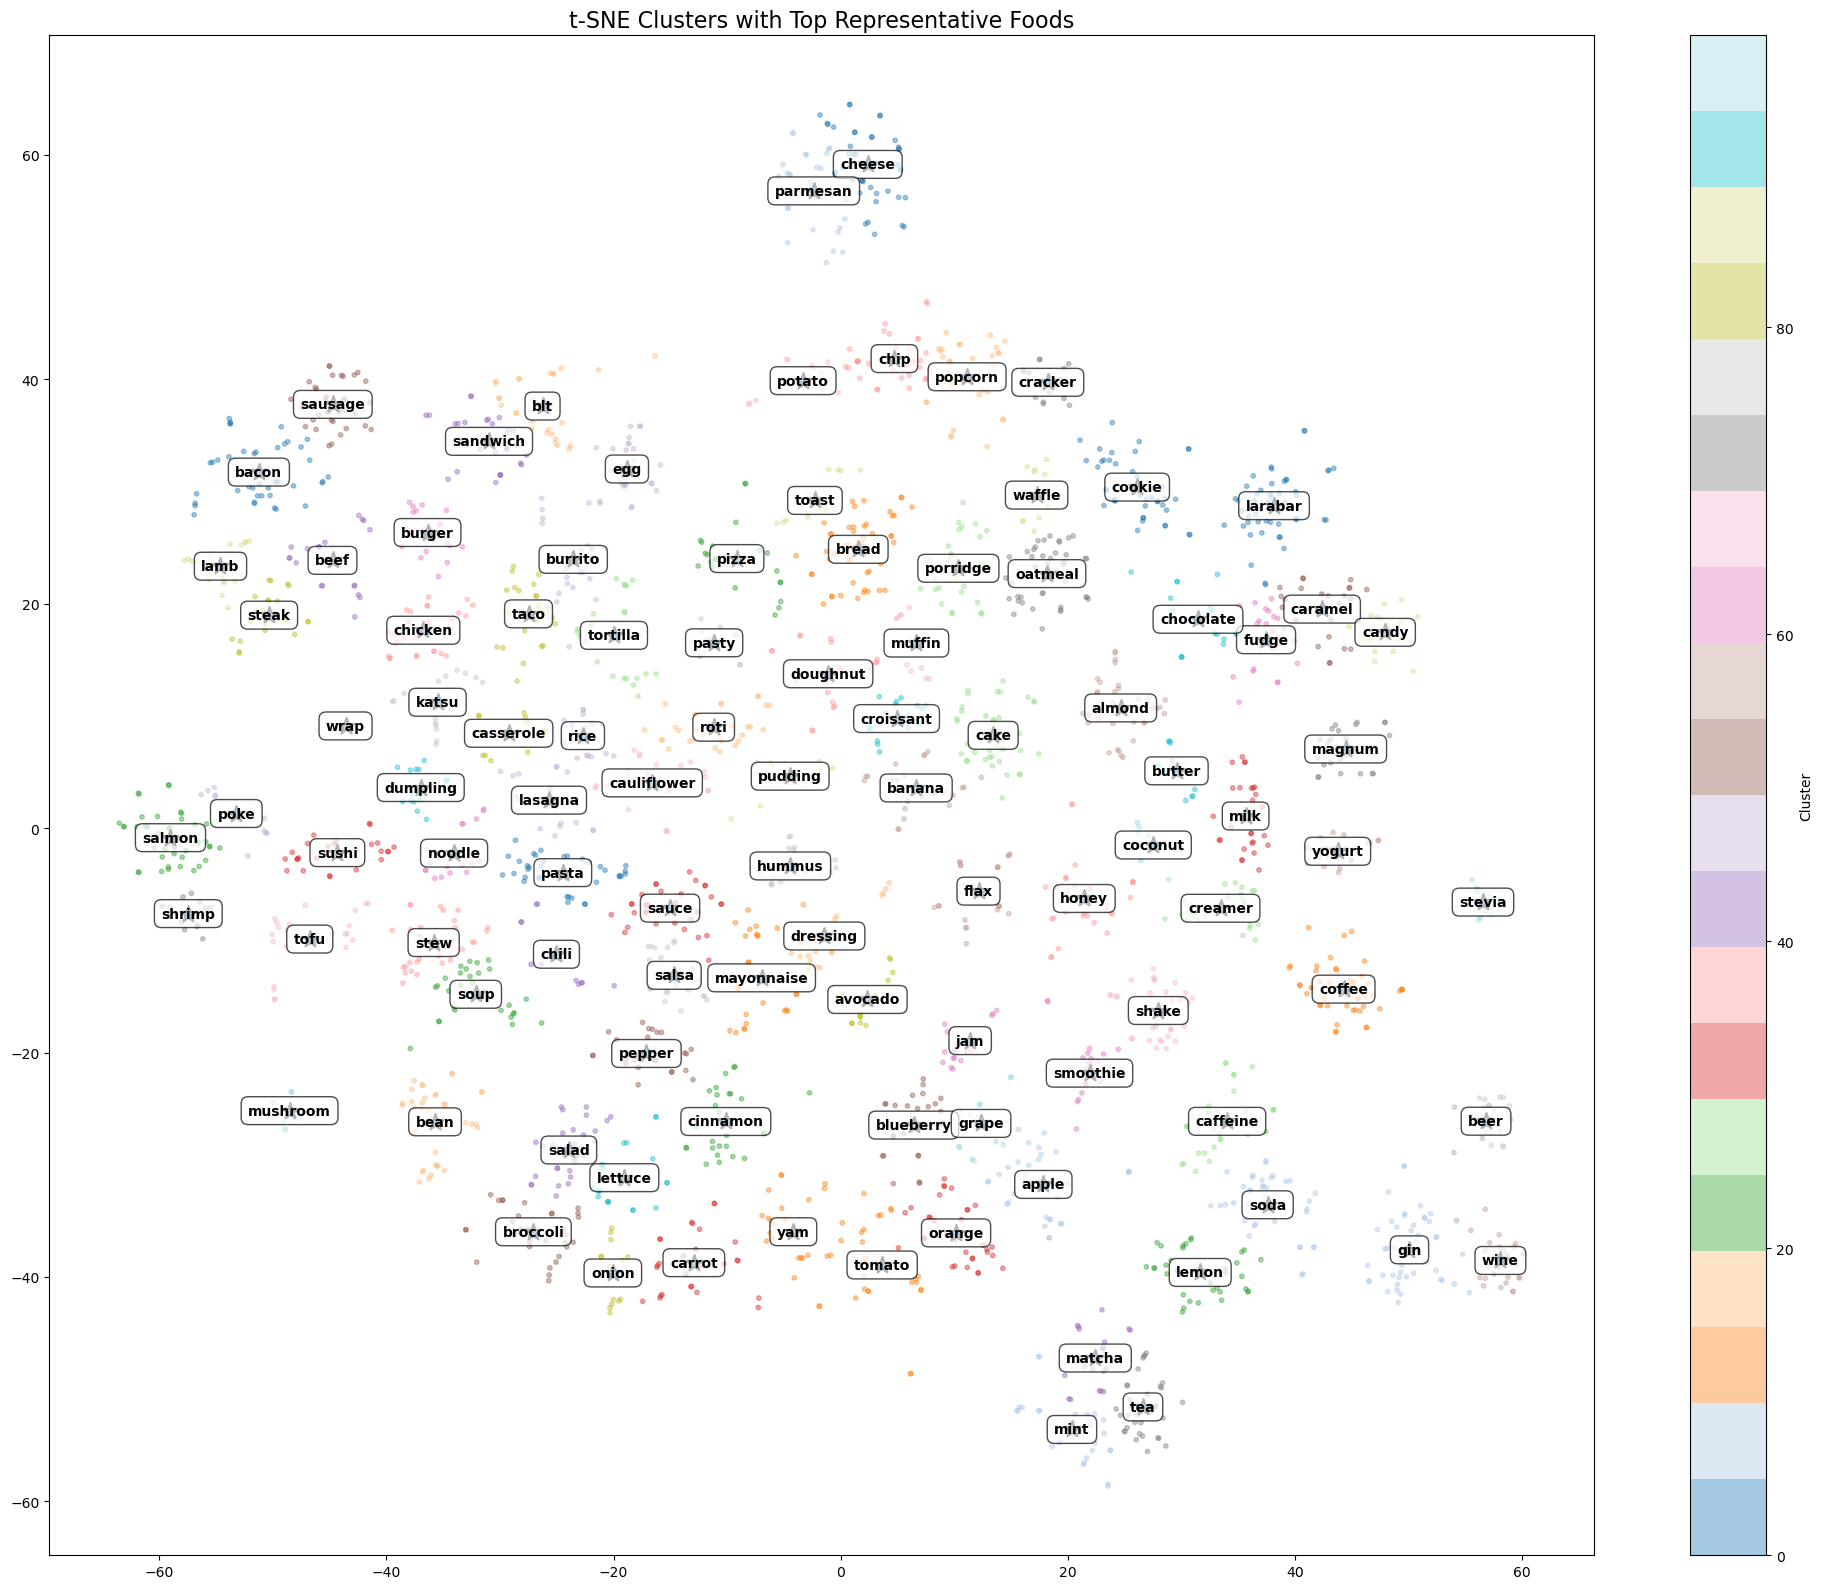

In [105]:
# Visualize t-SNE clusters with the original food names as labels
plt.figure(figsize=(20, 16))

# Plot all points with cluster colors
scatter = plt.scatter(reduced_df['tsne_1'], reduced_df['tsne_2'], 
                     c=reduced_df['hierarchical_cluster'], cmap='tab20', 
                     alpha=0.4, s=10)

# Calculate cluster centroids for label placement
cluster_centroids = {}
for cluster in sorted(reduced_df['hierarchical_cluster'].unique()):
    cluster_points = reduced_df[reduced_df['hierarchical_cluster'] == cluster]
    cluster_centroids[cluster] = (
        cluster_points['tsne_1'].mean(),
        cluster_points['tsne_2'].mean()
    )

# Add top representative for each cluster
for cluster, reps in weighted_representatives.items():
    if not reps:  # Skip empty clusters
        continue
    
    # Get the top representative (highest combined score)
    top_rep = sorted(reps, key=lambda x: x['combined_score'], reverse=True)[0]
    food_name = top_rep['food_name']
    
    # Get coordinates for centroid
    centroid_x, centroid_y = cluster_centroids[cluster]
    
    # Plot the cluster centroid as a star
    plt.scatter(centroid_x, centroid_y, 
                s=150, marker='*', edgecolor='black', linewidth=1.5,
                c=[cluster], cmap='tab20')
    
    # Add label with just the food name (no description)
    plt.annotate(
        food_name,
        (centroid_x, centroid_y),
        fontsize=10,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'),
        ha='center',
        va='center',
        xytext=(0, 0),  # No offset
        textcoords='offset points'
    )

plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Clusters with Top Representative Foods', fontsize=16)
plt.tight_layout()
plt.show()

Frequency stats - Min: 0, Max: 192480, Median: 0.0


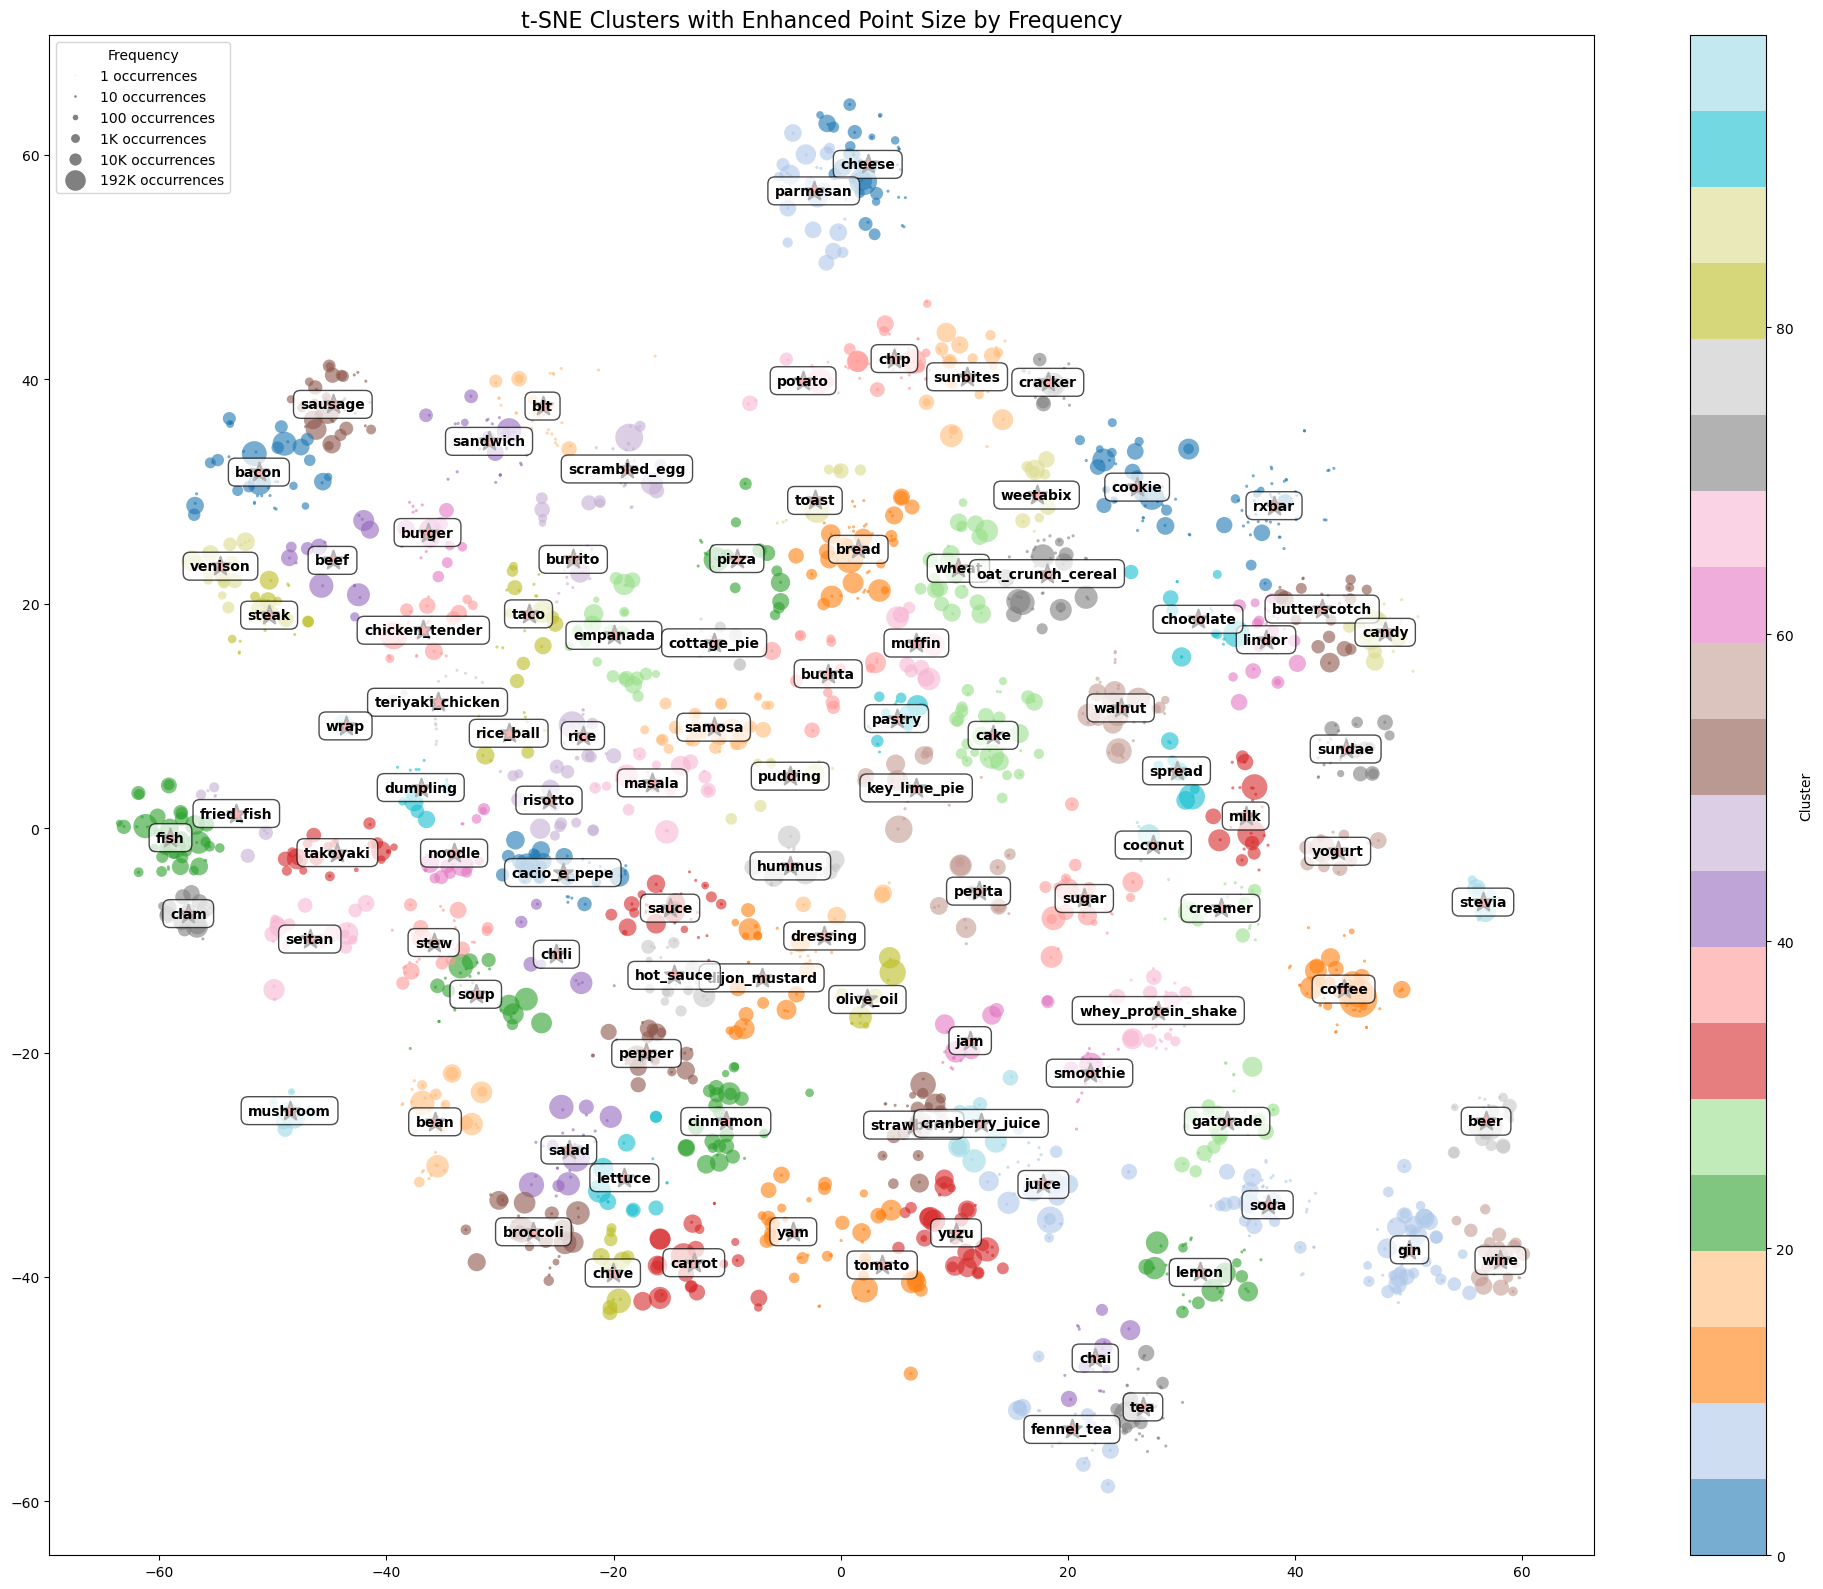

In [100]:
# Visualize t-SNE clusters with color by cluster and better size scaling for frequency
plt.figure(figsize=(20, 16))

# Map frequencies to the reduced_df
reduced_df_with_freq = reduced_df.copy()
reduced_df_with_freq['frequency'] = reduced_df_with_freq['food_name'].map(lambda x: frequencies.get(x, 0))

# Calculate statistics about frequency distribution
min_freq = reduced_df_with_freq['frequency'].min()
max_freq = reduced_df_with_freq['frequency'].max()
median_freq = reduced_df_with_freq['frequency'].median()
print(f"Frequency stats - Min: {min_freq}, Max: {max_freq}, Median: {median_freq}")

# Apply a more aggressive log transformation for better size scaling
# This will make high-frequency items more prominent
if max_freq > 0:
    # Base size is 5, max size is 500 (much larger than before)
    # Using a power transformation with higher exponent for more emphasis on high values
    reduced_df_with_freq['size'] = 5 + 495 * (np.log1p(reduced_df_with_freq['frequency']) / np.log1p(max_freq))**2
    
    # For very high frequencies, make them even more prominent
    highest_freq_threshold = max_freq * 0.5  # 50% of max as threshold
    very_frequent_items = reduced_df_with_freq['frequency'] > highest_freq_threshold
    if very_frequent_items.any():
        # Give extra size boost to very frequent items
        reduced_df_with_freq.loc[very_frequent_items, 'size'] *= 1.5
else:
    reduced_df_with_freq['size'] = 5

# Plot points with cluster colors and enhanced size by frequency
scatter = plt.scatter(
    reduced_df_with_freq['tsne_1'], 
    reduced_df_with_freq['tsne_2'],
    c=reduced_df_with_freq['hierarchical_cluster'],  # Color by cluster
    cmap='tab20',
    s=reduced_df_with_freq['size'],  # Size by frequency with enhanced scaling
    alpha=0.6,
    edgecolors='none'
)

# Add a colorbar for clusters
plt.colorbar(scatter, label='Cluster')

# Add a legend for point sizes with more intuitive frequency values
# Choose representative frequency values from the actual distribution
if max_freq > 0:
    # Use a more intuitive spread of frequencies for the legend
    legend_freqs = [1, 10, 100, 1000, 10000, max_freq]
    legend_freqs = [f for f in legend_freqs if f <= max_freq]  # Keep only valid frequencies
    
    legend_sizes = []
    for freq in legend_freqs:
        # Calculate size using the same formula as above
        size = 5 + 495 * (np.log1p(freq) / np.log1p(max_freq))**2
        if freq > highest_freq_threshold:
            size *= 1.5
        legend_sizes.append(size)
    
    # Create dummy scatter points for the legend
    legend_elements = []
    for size, freq in zip(legend_sizes, legend_freqs):
        # Format frequency numbers with K for thousands
        if freq >= 1000:
            freq_label = f"{freq/1000:.0f}K"
        else:
            freq_label = f"{freq:.0f}"
        
        legend_elements.append(plt.Line2D(
            [0], [0], marker='o', color='w', 
            label=f"{freq_label} occurrences",
            markerfacecolor='gray', 
            markersize=np.sqrt(size/3)  # Scale down for legend
        ))

    plt.legend(handles=legend_elements, title="Frequency", loc="upper left")

# Calculate cluster centroids for label placement
cluster_centroids = {}
for cluster in sorted(reduced_df['hierarchical_cluster'].unique()):
    cluster_points = reduced_df[reduced_df['hierarchical_cluster'] == cluster]
    cluster_centroids[cluster] = (
        cluster_points['tsne_1'].mean(),
        cluster_points['tsne_2'].mean()
    )

# Add top representative for each cluster
for cluster, reps in weighted_representatives.items():
    if not reps:  # Skip empty clusters
        continue
    
    # Get the top representative (highest combined score)
    top_rep = sorted(reps, key=lambda x: x['combined_score'], reverse=True)[0]
    food_name = top_rep['food_name']
    
    # Get coordinates for centroid
    centroid_x, centroid_y = cluster_centroids[cluster]
    
    # Plot the cluster centroid as a star
    plt.scatter(centroid_x, centroid_y, 
                s=200, marker='*', edgecolor='black', linewidth=1.5,
                c='red')  # Use a fixed color for stars to make them visible
    
    # Add label with just the food name (no description)
    plt.annotate(
        food_name,
        (centroid_x, centroid_y),
        fontsize=10,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'),
        ha='center',
        va='center',
        xytext=(0, 0),  # No offset
        textcoords='offset points'
    )

plt.title('t-SNE Clusters with Enhanced Point Size by Frequency', fontsize=16)
plt.tight_layout()
plt.savefig('tsne_clusters_with_enhanced_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from collections import defaultdict

def generate_cluster_summaries(reduced_df, weighted_representatives, embeddings_dict):
    """
    Generate comprehensive summaries for each food cluster including macronutrient profiles,
    characteristic foods, and statistical variance measures.
    """
    cluster_summaries = {}
    
    # Process each cluster
    for cluster in sorted(reduced_df['hierarchical_cluster'].unique()):
        if cluster == -1:  # Skip noise cluster if any
            continue
            
        # Get all foods in this cluster
        cluster_foods = reduced_df[reduced_df['hierarchical_cluster'] == cluster]['food_name'].tolist()
        
        # Get representative foods from weighted_representatives
        if cluster in weighted_representatives:
            rep_foods = [rep['food_name'] for rep in weighted_representatives[cluster]]
        else:
            rep_foods = []
        
        # Collect macronutrient data and serving sizes for foods in this cluster
        macro_data = defaultdict(list)
        pct_data = defaultdict(list)  # For storing percentage data per food
        serving_sizes = []
        valid_foods = 0
        
        for food in cluster_foods:
            try:
                # Extract nutrition data if available
                if food in embeddings_dict:
                    food_data = json.loads(embeddings_dict[food]['item_text'])
                    
                    # Get serving size
                    if 'serving_size' in food_data and 'grams' in food_data['serving_size']:
                        serving_size = food_data['serving_size']['grams']
                        if serving_size is not None:
                            serving_sizes.append(serving_size)
                    
                    # Get macronutrient data
                    if 'macronutrients_per_100g' in food_data:
                        macros = food_data['macronutrients_per_100g']
                        
                        # Store raw macronutrient values
                        for key in ['calories', 'protein', 'fat', 'carbohydrates', 'fiber', 'sugar']:
                            if key in macros and macros[key] is not None:
                                macro_data[key].append(macros[key])
                        
                        # Calculate and store percentage data for this food
                        if macros.get('calories', 0) > 0:
                            if macros.get('protein') is not None:
                                pct_data['protein'].append((macros['protein'] * 4 / macros['calories']) * 100)
                            if macros.get('fat') is not None:
                                pct_data['fat'].append((macros['fat'] * 9 / macros['calories']) * 100)
                            if macros.get('carbohydrates') is not None:
                                pct_data['carbohydrates'].append((macros['carbohydrates'] * 4 / macros['calories']) * 100)
                            if macros.get('sugar') is not None:
                                pct_data['sugar'].append((macros['sugar'] * 4 / macros['calories']) * 100)
                        
                        valid_foods += 1
            except:
                # Skip foods with parsing issues
                continue
        
        # Calculate statistics for macronutrients
        macro_stats = {}
        for key, values in macro_data.items():
            if values:
                macro_stats[key] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'cv': np.std(values) / np.mean(values) if np.mean(values) > 0 else 0  # Coefficient of variation
                }
            else:
                macro_stats[key] = None
        
        # Calculate statistics for percentage data
        pct_stats = {}
        for key, values in pct_data.items():
            if values:
                pct_stats[key] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'cv': np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
                }
            else:
                pct_stats[key] = None
        
        # Calculate serving size statistics
        serving_stats = {}
        if serving_sizes:
            serving_stats = {
                'mean': np.mean(serving_sizes),
                'std': np.std(serving_sizes),
                'min': np.min(serving_sizes),
                'max': np.max(serving_sizes),
                'cv': np.std(serving_sizes) / np.mean(serving_sizes) if np.mean(serving_sizes) > 0 else 0
            }
        
        # Get top representative foods
        top_representatives = rep_foods[:5] if rep_foods else []
        
        # Build summary
        summary = {
            'cluster_id': cluster,
            'num_foods': len(cluster_foods),
            'top_representatives': top_representatives,
            'macro_stats': macro_stats,
            'pct_stats': pct_stats,
            'serving_stats': serving_stats,
            'valid_nutrition_count': valid_foods,
            'primary_representative': rep_foods[0] if rep_foods else None
        }
        
        # Add text description
        summary['description'] = f"Cluster {cluster}: {summary['primary_representative']}"
        if valid_foods > 0:
            summary['description'] += f" - {valid_foods}/{len(cluster_foods)} items with nutrition data"
            
            # Add serving size information
            if serving_stats:
                summary['description'] += f"\nServing size: {serving_stats['mean']:.1f}g ± {serving_stats['std']:.1f} [range: {serving_stats['min']:.1f}-{serving_stats['max']:.1f}g] (CV: {serving_stats['cv']:.2f})"
            
            # Add macronutrient content
            if macro_stats.get('calories'):
                summary['description'] += "\nNutrition per 100g:"
                summary['description'] += f"\n  Calories: {macro_stats['calories']['mean']:.1f} ± {macro_stats['calories']['std']:.1f} [range: {macro_stats['calories']['min']:.1f}-{macro_stats['calories']['max']:.1f}] (CV: {macro_stats['calories']['cv']:.2f})"
                
                if macro_stats.get('protein'):
                    summary['description'] += f"\n  Protein: {macro_stats['protein']['mean']:.1f}g ± {macro_stats['protein']['std']:.1f} [range: {macro_stats['protein']['min']:.1f}-{macro_stats['protein']['max']:.1f}g] (CV: {macro_stats['protein']['cv']:.2f})"
                
                if macro_stats.get('fat'):
                    summary['description'] += f"\n  Fat: {macro_stats['fat']['mean']:.1f}g ± {macro_stats['fat']['std']:.1f} [range: {macro_stats['fat']['min']:.1f}-{macro_stats['fat']['max']:.1f}g] (CV: {macro_stats['fat']['cv']:.2f})"
                
                if macro_stats.get('carbohydrates'):
                    summary['description'] += f"\n  Carbs: {macro_stats['carbohydrates']['mean']:.1f}g ± {macro_stats['carbohydrates']['std']:.1f} [range: {macro_stats['carbohydrates']['min']:.1f}-{macro_stats['carbohydrates']['max']:.1f}g] (CV: {macro_stats['carbohydrates']['cv']:.2f})"
                
                if macro_stats.get('fiber'):
                    summary['description'] += f"\n  Fiber: {macro_stats['fiber']['mean']:.1f}g ± {macro_stats['fiber']['std']:.1f} [range: {macro_stats['fiber']['min']:.1f}-{macro_stats['fiber']['max']:.1f}g] (CV: {macro_stats['fiber']['cv']:.2f})"
                
                if macro_stats.get('sugar'):
                    summary['description'] += f"\n  Sugar: {macro_stats['sugar']['mean']:.1f}g ± {macro_stats['sugar']['std']:.1f} [range: {macro_stats['sugar']['min']:.1f}-{macro_stats['sugar']['max']:.1f}g] (CV: {macro_stats['sugar']['cv']:.2f})"
            
            # Add macronutrient percentages
            summary['description'] += "\nMacronutrient ratio (% of calories):"
            if pct_stats.get('protein'):
                summary['description'] += f"\n  Protein: {pct_stats['protein']['mean']:.1f}% ± {pct_stats['protein']['std']:.1f} [range: {pct_stats['protein']['min']:.1f}-{pct_stats['protein']['max']:.1f}%] (CV: {pct_stats['protein']['cv']:.2f})"
            
            if pct_stats.get('fat'):
                summary['description'] += f"\n  Fat: {pct_stats['fat']['mean']:.1f}% ± {pct_stats['fat']['std']:.1f} [range: {pct_stats['fat']['min']:.1f}-{pct_stats['fat']['max']:.1f}%] (CV: {pct_stats['fat']['cv']:.2f})"
            
            if pct_stats.get('carbohydrates'):
                summary['description'] += f"\n  Carbs: {pct_stats['carbohydrates']['mean']:.1f}% ± {pct_stats['carbohydrates']['std']:.1f} [range: {pct_stats['carbohydrates']['min']:.1f}-{pct_stats['carbohydrates']['max']:.1f}%] (CV: {pct_stats['carbohydrates']['cv']:.2f})"
            
            if pct_stats.get('sugar'):
                summary['description'] += f"\n  Sugar: {pct_stats['sugar']['mean']:.1f}% ± {pct_stats['sugar']['std']:.1f} [range: {pct_stats['sugar']['min']:.1f}-{pct_stats['sugar']['max']:.1f}%] (CV: {pct_stats['sugar']['cv']:.2f})"
        
        summary['description'] += f"\nTop representative foods: {', '.join(top_representatives)}"
        
        # Store in results dictionary
        cluster_summaries[cluster] = summary
    
    return cluster_summaries

# Generate the summaries
cluster_summaries = generate_cluster_summaries(reduced_df, weighted_representatives, embeddings_dict)

# Print formatted summaries
print("FOOD CLUSTER SUMMARIES\n")
print("=" * 80)

for cluster_id, summary in sorted(cluster_summaries.items()):
    print(f"\n{summary['description']}")
    print("-" * 80)

FOOD CLUSTER SUMMARIES


Cluster 0: pasta - 38/38 items with nutrition data
Serving size: 96.6g ± 67.7 [range: 14.0-250.0g] (CV: 0.70)
Nutrition per 100g:
  Calories: 314.7 ± 123.0 [range: 112.0-575.0] (CV: 0.39)
  Protein: 10.5g ± 4.2 [range: 2.5-26.0g] (CV: 0.41)
  Fat: 14.4g ± 17.4 [range: 0.2-55.8g] (CV: 1.21)
  Carbs: 36.1g ± 27.9 [range: 5.2-75.0g] (CV: 0.77)
  Fiber: 2.5g ± 2.0 [range: 0.0-12.0g] (CV: 0.79)
  Sugar: 1.8g ± 0.9 [range: 0.1-4.0g] (CV: 0.50)
Macronutrient ratio (% of calories):
  Protein: 13.9% ± 4.9 [range: 5.7-30.1%] (CV: 0.35)
  Fat: 37.6% ± 33.0 [range: 1.3-90.0%] (CV: 0.88)
  Carbs: 48.3% ± 29.6 [range: 5.1-82.9%] (CV: 0.61)
  Sugar: 2.7% ± 2.0 [range: 0.5-9.1%] (CV: 0.72)
Top representative foods: pasta, spaghetti, carbonara, cacio_e_pepe, macaroni
--------------------------------------------------------------------------------

Cluster 1: cheese - 46/46 items with nutrition data
Serving size: 29.2g ± 10.7 [range: 21.0-100.0g] (CV: 0.37)
Nutrition per 100g:
 